In [315]:
# Imports
import numpy as np
import matplotlib.pylab as plt
from zipfile import ZipFile

import sklearn.datasets
from sklearn.model_selection import train_test_split
import sklearn.metrics
import sklearn.model_selection
from sklearn.svm import SVC

from collections import Counter
import random

from janome.tokenizer import Tokenizer as janome_tokenizer

token_object = janome_tokenizer()

In [14]:
# Loading data
zpath = "Japanese.zip" 
with ZipFile(zpath) as zipObj:
    zipObj.extractall()

JPpath = "Japanese" 
data = sklearn.datasets.load_files(JPpath, encoding='utf-8')

# Fields:
# data, filenames, target_names, target, DESCR
print("Filenames:\n\t", data['filenames'])
print("Target names:\n\t", data['target_names'])
print("Targets:\n\t", data['target'])

Filenames:
	 ['Japanese\\Caroll\\Feeding the Mind JP.txt'
 'Japanese\\Dostroevsky\\Crime and Punishment JP.txt'
 'Japanese\\Dostroevsky\\The Eternal Husband JP.txt'
 'Japanese\\Doyle\\A Scandal in Bohemia JP.txt'
 'Japanese\\Souseki\\Kokoro JP.txt' 'Japanese\\Dazai\\Pandoras Box JP.txt'
 'Japanese\\Caroll\\What the Tortoise Said to Achilles JP.txt'
 'Japanese\\Souseki\\I am a cat JP.txt'
 'Japanese\\Doyle\\The Adventure of the Dancing Men JP.txt'
 'Japanese\\Dostroevsky\\The Brothers Karamazov JP.txt'
 'Japanese\\Doyle\\The Red-Headed League JP.txt'
 'Japanese\\Dazai\\No Longer Human JP.txt'
 'Japanese\\Caroll\\Alice in Wonderland JP.txt'
 'Japanese\\Dazai\\Setting Sun JP.txt' 'Japanese\\Souseki\\Botchan JP.txt']
Target names:
	 ['Caroll', 'Dazai', 'Dostroevsky', 'Doyle', 'Souseki']
Targets:
	 [0 2 2 3 4 1 0 4 3 2 3 1 0 1 4]


In [46]:
test = "これは猫です"

for token in token_object.tokenize(test):
    print(token.surface, token.phonetic)

これ コレ
は ワ
猫 ネコ
です デス


In [47]:
%%time

# Preprocessing

tokenized = []

for i, text in enumerate(data['data']):
    print("Tokenizing... " + str(i) + "/" + str(len(data['filenames'])))
    print("Current file:", data['filenames'][i])
    tokenized.append([x for x in token_object.tokenize(text)])

Tokenizing... 0/15
Current file: Japanese\Caroll\Feeding the Mind JP.txt
Tokenizing... 1/15
Current file: Japanese\Dostroevsky\Crime and Punishment JP.txt
Tokenizing... 2/15
Current file: Japanese\Dostroevsky\The Eternal Husband JP.txt
Tokenizing... 3/15
Current file: Japanese\Doyle\A Scandal in Bohemia JP.txt
Tokenizing... 4/15
Current file: Japanese\Souseki\Kokoro JP.txt
Tokenizing... 5/15
Current file: Japanese\Dazai\Pandoras Box JP.txt
Tokenizing... 6/15
Current file: Japanese\Caroll\What the Tortoise Said to Achilles JP.txt
Tokenizing... 7/15
Current file: Japanese\Souseki\I am a cat JP.txt
Tokenizing... 8/15
Current file: Japanese\Doyle\The Adventure of the Dancing Men JP.txt
Tokenizing... 9/15
Current file: Japanese\Dostroevsky\The Brothers Karamazov JP.txt
Tokenizing... 10/15
Current file: Japanese\Doyle\The Red-Headed League JP.txt
Tokenizing... 11/15
Current file: Japanese\Dazai\No Longer Human JP.txt
Tokenizing... 12/15
Current file: Japanese\Caroll\Alice in Wonderland JP.tx

In [89]:
# First check the total TOKEN length per author
print("Amount of extracted tokens per author:")

for i in range(max(data['target'])+1):
    indices = np.where(data['target'] == i)

    print(data['target_names'][i], ":", sum([len(tokenized[i]) for i in np.array(indices)[0]]))
print()

# Check total character lenght per author
print("Amount of characters per author:")

for i in range(max(data['target'])+1):
    indices = np.where(data['target'] == i)
    
    print(data['target_names'][i], ":", sum([len(data['data'][i]) for i in np.array(indices)[0]]))

Amount of extracted tokens per author:
Caroll : 45261
Dazai : 160790
Dostroevsky : 758110
Doyle : 43955
Souseki : 374268

Amount of characters per author:
Caroll : 76235
Dazai : 250777
Dostroevsky : 1263457
Doyle : 68859
Souseki : 573601


In [278]:
%%time

# Check common words, and how common names are

i = 3

surface = [x.surface for x in tokenized[i]]
counts = {item:surface.count(item) for item in surface}
x = Counter(counts)
for c in x.most_common(25):
    print(c)
print()

# Make names into a discussion thing, beyond the scope of this project
# Since APPARENTLY the text is too large for python to handle rip

('。', 699)
('、', 679)
('の', 463)
('は', 384)
('に', 361)
('た', 355)
('を', 333)
('て', 285)
('\n', 270)
('が', 261)
('「', 249)
('」', 249)
('と', 244)
('で', 219)
('だ', 164)
('し', 127)
('も', 107)
('な', 91)
('ホームズ', 90)
('こと', 75)
('か', 73)
('\u3000', 67)
('う', 64)
('から', 61)
('ある', 61)

CPU times: total: 5.58 s
Wall time: 5.6 s


In [130]:
# Split into smaller parts, update the target list to reflect that
target = []
data_split = []

string_cut = ""
n = 5

# Make cuts of 5 sentences per new part
for i, t in enumerate(data['target']):
    
    for j in range(len(data['data'][i])):

        string_cut += data['data'][i][j]

        if data['data'][i][j] == "。" or data['data'][i][j] == "！":
            n-=1

        if n<0:
            data_split.append(string_cut)
            target.append(t)
            n = 5
            string_cut = ""

In [244]:
# Make an equal selection of parts so all authors are equally represented

print("Before equalizing authors:")
author_count = {data['target_names'][item]:target.count(item) for item in target}
print(author_count)

i_rand = []

# Get a random sample of the size of the author with the least parts
for t in range(max(data['target'])+1):
    
    target_indices = list(np.where(target == np.int32(t))[0])
    random_sample = random.sample(target_indices, k = min(author_count.values())) 
    i_rand.append(random_sample)
    
i_rand = [item for sublist in i_rand for item in sublist] # -> flatten

# This is the final data we're working with
data_cut = [data_split[i] for i in i_rand]  
target_cut = [target[i] for i in i_rand]         

print()
print("After equalizing authors:")
author_count = {data['target_names'][item]:target_cut.count(item) for item in target_cut}
print(author_count)

Before equalizing authors:
{'Caroll': 364, 'Dostroevsky': 4415, 'Doyle': 342, 'Souseki': 2433, 'Dazai': 977}

After equalizing authors:
{'Caroll': 342, 'Dazai': 342, 'Dostroevsky': 342, 'Doyle': 342, 'Souseki': 342}


In [300]:
# Train test set generation
X_train, X_test, y_train, y_test = train_test_split(data_cut, target_cut, test_size=0.2, random_state=1)

In [246]:
def contains_character(token, characters):
    for char in token:
        if char in characters:
            return True
    return False

In [290]:
# Extract features from a given text
def extract_features(text, leave_out=0):
    '''
    text: The text we want to extract features from
    plot: Which features we want to leave out:
        0: None
        1: Lexical features
        2: Character features
        3: POS tags
        4: Function words
    '''
    
    bag_of_words = [token for token in token_object.tokenize(text)]
    
    particles = ["が", "の", "を", "に", "へ", "と", "で", "から", "より",
                "か", "や", "やら", "なり", "だの", "な", "わ", "とも", "かしら",
                "さ", "よ", "ね", "ばかり", "まで", "だけ", "ほど", "くらい", "など",
                "は", "も", "こそ", "でも", "しか", "さえ", "だに", "ば", "て", 
                "のに", "ので", "ところが", "けれども", "くせに"]
    pos_tags = ["名詞", "固有名詞", "形式名詞", "動詞", "助動詞", "複合動詞", "形容詞", "形容動詞",
               "連体詞", "前置詞", "接尾語", "辞書形", "普通形", "丁寧形", "不定詞", "活用形", "終止形",
               "命令形", "使役形", "四段活用", "条件形", "助数詞", "対比", "否定", "打消し", "強調",
               "簡略化", "筆者", "確認", "説明", "伝聞", "目的", "不可避", "敬語", "副助詞", "擬態語", "同義語"]
    stopwords = ["あそこ", "あっ", "あの", "あのかた", "あの人", "あり", "あります", "ある", "あれ", "い", "いう",
                  "います", "いる", "う", "うち", "え", "お", "および", "おり", "おります", "か", "かつて", "から",
                  "が", "き", "ここ", "こちら", "こと", "この", "これ", "これら", "さ", "さらに", "し", "しかし",
                  "する", "ず", "せ", "せる", "そこ", "そして", "その", "その他", "その後", "それ", "それぞれ",
                  "それで", "た", "ただし", "たち", "ため", "たり", "だ", "だっ", "だれ", "つ", "て", "で", "でき",
                  "できる", "です", "では", "でも", "と", "という", "といった", "とき", "ところ", "として", "とともに",
                  "とも", "と共に", "どこ", "どの", "な", "ない", "なお", "なかっ", "ながら", "なく", "なっ", "など",
                  "なに", "なら", "なり", "なる", "なん", "に", "において", "における", "について", "にて", "によって",
                  "により", "による", "に対して", "に対する", "に関する", "の", "ので", "のみ", "は", "ば", "へ",
                  "ほか", "ほとんど", "ほど", "ます", "また", "または", "まで", "も", "もの", "ものの", "や", "よう",
                  "より", "ら", "られ", "られる", "れ", "れる", "を", "ん", "何", "及び", "彼", "彼女", "我々", "特に",
                  "私", "私達", "貴方", "貴方方"]
    hiragana = ["ぁ", "あ", "ぃ", "い", "ぅ", "う", "ぇ", "え", "ぉ", "お", "か", "が", "き", "ぎ", "く", "ぐ", "け",
                "げ", "こ", "ご", "さ", "ざ", "し", "じ", "す", "ず", "せ", "ぜ", "そ", "ぞ", "た", "だ", "ち", "ぢ",
                "っ", "つ", "づ", "て", "で", "と", "ど", "な", "に", "ぬ", "ね", "の", "は", "ば", "ぱ", "ひ", "び",
                "ぴ", "ふ", "ぶ", "ぷ", "へ", "べ", "ぺ", "ほ", "ぼ", "ぽ", "ま", "み", "む", "め", "も", "ゃ", "や",
                "ゅ", "ゆ", "ょ", "よ", "ら", "り", "る", "れ", "ろ", "ゎ", "わ", "ゐ", "ゑ", "を", "ん", "ゔ"]
    katakana = ["ァ", "ア", "ィ", "イ", "ゥ", "ウ", "ェ", "エ", "ォ", "オ", "カ", "ガ", "キ", "ギ", "ク", "グ", "ケ", 
                "ゲ", "コ", "ゴ", "サ", "ザ", "シ", "ジ", "ス", "ズ", "セ", "ゼ", "ソ", "ゾ", "タ", "ダ", "チ", "ヂ", 
                "ッ", "ツ", "ヅ", "テ", "デ", "ト", "ド", "ナ", "ニ", "ヌ", "ネ", "ノ", "ハ", "バ", "パ", "ヒ", "ビ", 
                "ピ", "フ", "ブ", "プ", "ヘ", "ベ", "ペ", "ホ", "ボ", "ポ", "マ", "ミ", "ム", "メ", "モ", "ャ", "ヤ", 
                "ュ", "ユ", "ョ", "ヨ", "ラ", "リ", "ル", "レ", "ロ", "ヮ", "ワ", "ヰ", "ヱ", "ヲ", "ン", "ヴ", "ヵ", 
                "ヶ", "ヷ", "ヸ", "ヹ", "ヺ"]
    features = []
    
    # LEXICAL FEATURES
    if not leave_out == 1:
        
        # Count the number of tokens
        features.append(len(bag_of_words))
        
        # Amount of stopwords (normalized)
        features.append(len([token for token in bag_of_words if token.surface in stopwords])/len(bag_of_words))
        
        # Total number of sentences
        features.append(len([token for token in bag_of_words if token.surface in "。！"]))
        
        # Total amount of words with only kanji
        features.append(len([character for token in bag_of_words for character in token.surface
                             if character not in hiragana and character not in katakana]))

    
    # CHARACTER FEATURES
    
    if not leave_out == 2:
        
    # Total number of characters
        features.append(len(text))
        
    # Total phonetic count AKA non special characters
        features.append(len([character for token in bag_of_words for character in token.phonetic if character not in katakana]))
    
    # Total punctuation count
        features.append(len([character for token in bag_of_words for character in token.surface if contains_character(character, "。、「」？！")]))

    # Parenthesis/quotation count
        features.append(len([character for token in bag_of_words for character in token.surface if contains_character(character, "「」")]))

    # Frequency of sounds
    for kana in katakana: # For every letter in the phonetic alphabet

        # Count how many times that letter occurs
        kana_count = len([character for token in bag_of_words for character in token.phonetic if character in kana])
        
        # Normalize that number by the total amount of non whitespace characters
        normalized = kana_count/len([character for token in bag_of_words for character in token.surface])

        # Add that as a separate feature
        features.append(normalized)
    
    
    # POS TAGS
    if not leave_out == 3:

        # Parts of speech (POS) tags frequency
        for pos in pos_tags:
            features.append(len([token for token in bag_of_words if pos in token.part_of_speech]))
    
    
    # FUNCTION WORDS/ PARTICLES
    if not leave_out == 4:

        # Function words frequency
        for par in particles: # For every particle

            # Count how many times that word occurs
            par_count = len([token for token in bag_of_words if token.surface == par])
            
            # Add that as a separate feature
            features.append(par_count)
    
    return features

In [291]:
print("Amount of features extracted:", len(extract_features(X_train[0])))

print("Sample:")
print(extract_features(X_train[0]))

Amount of features extracted: 176
Sample:
[109, 0.5229357798165137, 6, 68, 167, 19, 11, 2, 0.0, 0.017964071856287425, 0.0, 0.11377245508982035, 0.0, 0.023952095808383235, 0.0, 0.011976047904191617, 0.0, 0.0, 0.059880239520958084, 0.017964071856287425, 0.017964071856287425, 0.0, 0.04790419161676647, 0.0, 0.005988023952095809, 0.0, 0.029940119760479042, 0.0, 0.005988023952095809, 0.017964071856287425, 0.08383233532934131, 0.011976047904191617, 0.011976047904191617, 0.005988023952095809, 0.023952095808383235, 0.005988023952095809, 0.011976047904191617, 0.011976047904191617, 0.04790419161676647, 0.011976047904191617, 0.005988023952095809, 0.0, 0.041916167664670656, 0.005988023952095809, 0.0, 0.041916167664670656, 0.017964071856287425, 0.041916167664670656, 0.0, 0.041916167664670656, 0.017964071856287425, 0.0, 0.0, 0.023952095808383235, 0.005988023952095809, 0.005988023952095809, 0.0, 0.0, 0.0, 0.0, 0.005988023952095809, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011976047904191617, 0.017964

In [292]:
# Classify using the features
def classify(train_features, train_labels, test_features):
    clf = SVC(kernel='linear')
    clf.fit(train_features, train_labels)
    return clf.predict(test_features)

In [293]:
# Evaluate predictions (y_pred) given the ground truth (y_true)
def evaluate(y_true, y_pred, verbose=True):
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='macro')
    # recall = sklearn.metrics.recall_score(y_true, y_pred, average='weighted')
    if verbose:
        print("Recall: %f" % recall)

    precision = sklearn.metrics.precision_score(y_true, y_pred, average='macro')
    # precision = sklearn.metrics.precision_score(y_true, y_pred, average='weighted')
    if verbose:
        print("Precision: %f" % precision)

    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    # f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
    if verbose:
        print("F1-score: %f" % f1_score)

    return recall, precision, f1_score

In [309]:
# Classify and evaluate
def classify_and_evaluate(verbose=True, leave_out=0):

    # Extract the features
    print("Extracting features...")
    features = list(map(extract_features, X_train, [leave_out for x in range(len(X_train))]))
    print("Done!")

    print("Amount of features extracted:", len(features[0]))

    skf = sklearn.model_selection.StratifiedKFold(n_splits=10)
    scores = []
    for fold_id, (train_indexes, validation_indexes) in enumerate(skf.split(X_train, y_train)):
        # Print the fold number
        if verbose:
            print("Fold %d" % (fold_id + 1))

        # Collect the data for this train/validation split
        train_features = [features[x] for x in train_indexes]
        train_labels = [y_train[x] for x in train_indexes]

        validation_features = [features[x] for x in validation_indexes]
        validation_labels = [y_train[x] for x in validation_indexes]

        # Classify and add the scores to be able to average later
        y_pred = classify(train_features, train_labels, validation_features)

        scores.append(evaluate(validation_labels, y_pred, verbose))

        # Print a newline
        if verbose:
            print("")

    # Print the averaged score
    recall = sum([x[0] for x in scores]) / len(scores)
    if verbose:
        print("Averaged total recall", recall)
    precision = sum([x[1] for x in scores]) / len(scores)
    if verbose:
        print("Averaged total precision", precision)
    f_score = sum([x[2] for x in scores]) / len(scores)
    if verbose:
        print("Averaged total f-score", f_score)
        print("")

    test_features = list(map(extract_features, X_test, [leave_out for x in range(len(X_test))]))

    y_pred = classify(features, y_train, test_features)
    
    return evaluate(y_test, y_pred)

In [312]:
%%time

classify_and_evaluate(verbose=True, leave_out=0)

Extracting features...
Done!
Amount of features extracted: 176
Fold 1
Recall: 0.838889
Precision: 0.850573
F1-score: 0.839593

Fold 2
Recall: 0.853602
Precision: 0.865341
F1-score: 0.856162

Fold 3
Recall: 0.779711
Precision: 0.786682
F1-score: 0.778788

Fold 4
Recall: 0.745116
Precision: 0.746450
F1-score: 0.744012

Fold 5
Recall: 0.822283
Precision: 0.820085
F1-score: 0.819925

Fold 6
Recall: 0.767074
Precision: 0.776884
F1-score: 0.767585

Fold 7
Recall: 0.802330
Precision: 0.810400
F1-score: 0.804433

Fold 8
Recall: 0.783047
Precision: 0.797998
F1-score: 0.782841

Fold 9
Recall: 0.780159
Precision: 0.780169
F1-score: 0.779812

Fold 10
Recall: 0.750529
Precision: 0.760987
F1-score: 0.751749

Averaged total recall 0.7922740095153888
Averaged total precision 0.7995567700136955
Averaged total f-score 0.7924898459967669

Recall: 0.763609
Precision: 0.761384
F1-score: 0.760661
CPU times: total: 7min
Wall time: 6min 58s


(0.763608906554979, 0.7613838763856695, 0.7606609264672917)

In [313]:
%%time

# Leave out different feature groups
results = []
for i in range(5):
    results.append(classify_and_evaluate(verbose=False, leave_out=i)[2])

Extracting features...
Done!
Amount of features extracted: 176
Recall: 0.763609
Precision: 0.761384
F1-score: 0.760661
Extracting features...
Done!
Amount of features extracted: 172
Recall: 0.748307
Precision: 0.746942
F1-score: 0.747036
Extracting features...
Done!
Amount of features extracted: 172
Recall: 0.663773
Precision: 0.662980
F1-score: 0.661974
Extracting features...
Done!
Amount of features extracted: 139
Recall: 0.769686
Precision: 0.765143
F1-score: 0.765656
Extracting features...
Done!
Amount of features extracted: 135
Recall: 0.717860
Precision: 0.723129
F1-score: 0.718660
CPU times: total: 34min 6s
Wall time: 34min 7s


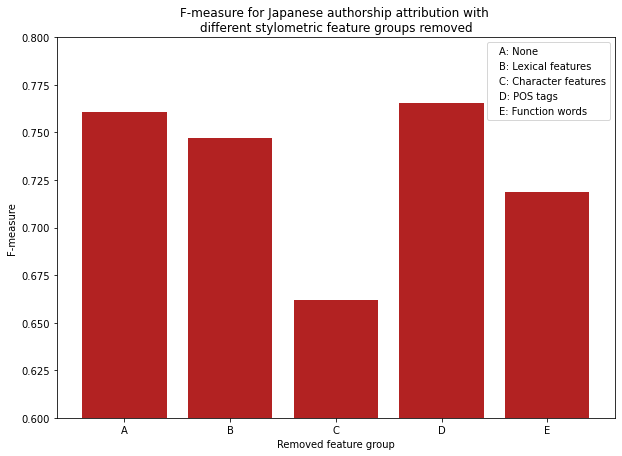

In [330]:
# Creating histogram
groups = ["A", "B", "C", "D", "E"]
labels = ["A: None", "B: Lexical features", "C: Character features", "D: POS tags", "E: Function words"]

fig, ax = plt.subplots(figsize =(10, 7))
for i in range(len(groups)):
    ax.bar(groups[i], results[i], label=labels[i], color='FireBrick')
plt.xlabel("Removed feature group")
plt.ylabel("F-measure")
plt.ylim((0.60, 0.80))
plt.legend(handlelength=0)
plt.title("F-measure for Japanese authorship attribution with \ndifferent stylometric feature groups removed")

# Show plot
plt.show()